In [1]:
%matplotlib inline
import os
import time
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

from caen_felib import lib, device, error

# Get CAEN FELib path
print(f'CAEN FELib found at: {lib.path} (version={lib.version})')

CAEN FELib found at: libCAEN_FELib.so (version=1.3.2)


In [2]:
from lgdo import lh5, Table, Array, WaveformTable, ArrayOfEqualSizedArrays

## Connect

In [ ]:
dig = device.connect("dig2://caendgtz-usb-66154")
print(f'Connected to digitizer (handle={hex(dig.handle)}, name={dig.name})')

In [ ]:
tree = dig.get_device_tree()

In [ ]:
for par, par_dict in tree["par"].items():
#for par in tree["ch"]["0"]["par"]:
    if isinstance(par_dict, dict) and "accessmode" in par_dict:
        #if par_dict['accessmode']['value'] == "READ_ONLY":#"READ_WRITE":
        if par not in ["itlamask"]: continue
        print(par_dict)
        alv = []
        if 'allowedvalues' in par_dict:
            allowedvalues = par_dict['allowedvalues']
            for a in allowedvalues:
                if isinstance(allowedvalues[a], dict):
                    alv.append(allowedvalues[a]["value"])
        def_val = ""
        if 'defaultvalue' in par_dict:
            def_val = par_dict['defaultvalue']['value']
        print(f"  {par}: {def_val} # ({par_dict['datatype']['value']}) [{alv}] {par_dict['description']['value']}")

In [ ]:
# Reset
dig.cmd.Reset()

fw_type = dig.par.fwtype.value
fw_ver = dig.par.fpga_fwver.value
print(fw_type, fw_ver)

adc_samplrate_msps = float(dig.par.adc_samplrate.value)  # in Msps
adc_n_bits = int(dig.par.adc_nbit.value)
sampling_period_ns = int(1e3 / adc_samplrate_msps)

print(f"Sampling rate = {adc_samplrate_msps} MHz, n. bit = {adc_n_bits}, Sampling period = {sampling_period_ns} ns")

# Configuration parameters
nch = int(dig.par.NumCh.value)
active_ch = 1
#reclen = 4084 #sample
reclen = 125000 #sample
pretrg = 2042 #sample
dc_offset = 10

dig.par.iolevel.value = "TTL"
dig.par.recordlengths.value = f"{reclen}"
dig.par.pretriggers.value = f"{pretrg}"

#dig.par.acqtriggersource.value = "TrgIn"
dig.par.acqtriggersource.value = "SwTrg"

# Set some channel parameters
for i, ch in enumerate(dig.ch):
    ch.par.chenable.value = "TRUE" if i < active_ch else "FALSE"  # Enable only channel 0
    ch.par.dcoffset.value = f"{dc_offset}"
    if i < active_ch:
        print(ch.par["dcoffset"].value)

## Configure endpoint

In [ ]:
data_format = [
    {
        'name': 'EVENT_SIZE',
        'type': 'SIZE_T',
    },
    {
        'name': 'TIMESTAMP',
        'type': 'U64',
    },
    {
        'name': 'WAVEFORM',
        'type': 'U16',
        'dim': 2,
        'shape': [active_ch, reclen],
    },
    {
        'name': 'WAVEFORM_SIZE',
        'type': 'U64',
        'dim': 1,
        'shape': [active_ch],
    },
]

In [ ]:
decoded_endpoint_path = "scope"
endpoint = dig.endpoint[decoded_endpoint_path]
data = endpoint.set_read_data_format(data_format)
dig.endpoint.par.ACTIVEENDPOINT.value = decoded_endpoint_path

event_size = data[0].value
timestamp = data[1].value
waveform = data[2].value
waveform_size = data[3].value

In [ ]:
nev = 10
timestamps = np.zeros((active_ch,nev),dtype=np.uint64)
wfs = np.zeros((active_ch,nev,reclen),dtype=np.uint16)
temp_names = ["tempsensfirstadc","tempsenshottestadc","tempsenslastadc","tempsensairin","tempsensairout","tempsenscore","tempsensdcdc"]
temperatures = np.zeros((nev,len(temp_names)),dtype=float)

In [ ]:
dig.cmd.armacquisition()
dig.cmd.swstartacquisition()
for i in range(nev):
    time.sleep(1/1000)
    dig.cmd.sendswtrigger() # to send software trigger
    try:
        endpoint.read_data(-1, data)
    except error.Error as ex:
        if ex.code == error.ErrorCode.TIMEOUT:
            continue
        if ex.code == error.ErrorCode.STOP:
            break
        else:
            raise ex
    for j in range(active_ch):
        wfs[j,i] = waveform[j]
        timestamps[j,i] = timestamp
        for k, temp in enumerate(temp_names):
            temp_value = float(dig.get_value(f"/par/{temp}"))
            temperatures[i][k] = temp_value
dig.cmd.disarmacquisition()

# Reading raw files

In [ ]:
run = "r007"
data_dir = f"/home/legendaryno/data/test_dec25/{run}"
raw_files = [os.path.join(data_dir, fname) for fname in sorted(os.listdir(data_dir))]

raw_data0 = lh5.read("ch000/raw",raw_files)
raw_data1 = lh5.read("ch001/raw",raw_files)

timestamp = raw_data0.timestamp.nda
wfs0 = raw_data0.waveform.values.nda
wfs1 = raw_data1.waveform.values.nda
print(wfs0.shape)
print(wfs1.shape)
dts = np.linspace(0,len(wfs0[0])*8/1000,len(wfs0[0]))

In [ ]:
wfs0_bl, wfs1_bl = np.zeros_like(wfs0,dtype=float), np.zeros_like(wfs0,dtype=float)
fig, ax = plt.subplots(2,figsize=(8,6.5))
for i in range(len(wfs0_bl)):
    ts = timestamp[i] - timestamp[0]
    wfs0_bl[i] = wfs0[i] - np.mean(wfs0[i,:100])
    wfs1_bl[i] = wfs1[i] - np.mean(wfs1[i,:100])
    if i < 100 and max(wfs0_bl[i]<5000) and max(wfs1_bl[i]<5000):
        ax[0].plot(dts,wfs0_bl[i])
        ax[1].plot(dts,wfs1_bl[i])
#ax.set_xlim(3.5,5)
#ax[0].set_ylim(-100,500)
ax[0].legend(title="SiPM 0",loc="upper right")
ax[1].legend(title="SiPM 1",loc="upper right")
ax[0].set_xlabel(r"Time ($\mu$s)")
ax[1].set_xlabel(r"Time ($\mu$s)")
ax[0].set_ylabel("ADC")
ax[1].set_ylabel("ADC")

In [14]:
wf0_max = np.max(wfs0_bl,axis=1)
wf1_max = np.max(wfs1_bl,axis=1)
print(wf0_max.shape)

(36500,)


Text(0.5, 1.0, 'LYno Accrocco')

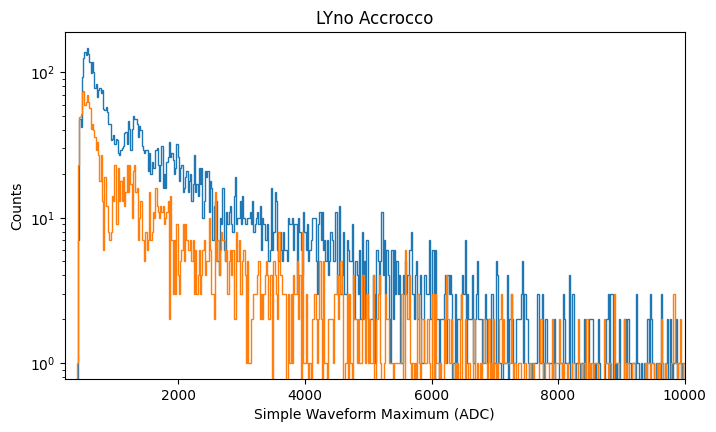

In [17]:
fig, ax = plt.subplots(figsize=(8,4.5))
ax.hist(wf0_max,histtype="step",bins=np.linspace(200,10000,500))
ax.hist(wf1_max,histtype="step",bins=np.linspace(200,10000,500))
ax.set_xlim(200,10000)
ax.set_yscale("log")
ax.set_xlabel("Simple Waveform Maximum (ADC)")
ax.set_ylabel("Counts")
ax.set_title("LYno Accrocco")

In [ ]:
mean_0 = np.mean(wfs0_bl,axis=0)
mean_1 = np.mean(wfs1_bl,axis=0)
fig, ax = plt.subplots(figsize=(8,4.5))
ax.plot(dts,mean_0,label="SiPM 0")
ax.plot(dts,mean_1,label="SiPM 1")
ax.legend()
ax.set_title("LYno Accrocco - Average Pulses")
ax.set_xlabel(r"Time ($\mu$s)")
ax.set_yscale("log")
ax.set_ylim(0.1,1e4)